# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology and Analysis](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

According to U.S. census data, since 2010 roughly 35.5 million Americans on average moved each year from one address to another. If that move includes moving from one city to another city, there are thousands of cities to choose from in the U.S. Determining which city to live is a complex decision. There are many factors that can contribute to the decision of which city to move, a few among them are cost of living, employment opportunities, education levels, available activities, and city size. Let's assume you are living in the U.S. and would like to move to a city which has a population of 100,000 people or greater. There are over 300 cities in the U.S. which have a population greater than 100,000 people. How would you begin to decide which city to choose from? We can use machine learning to cluster these 300 cities into different groups, each group with a different set of attributes. This will help you narrow down the search for a potential city to choose.

## Data <a name="data"></a>

We will be using different sets of data in our model of U.S. cities. The first source of data is from a Wikipedia page which contains a list of the largest U.S. cities by population for cities with 100,000 people or more. This list contains 314 cities based on 2018 population data.  

The next source of data is from the U.S. Census Bureau. The U.S. Census Bureau is a principal agency of the U.S. Federal Statistical System, responsible for producing data about the American people and economy. The census bureau provides city level data on the following categories: population characteristics, housing, education, income, and geography. One method to access this data is through a feature called QuickFacts, which provides statistics for all states and counties, and for cities and towns with a population of 5,000 or more. The user must search for a specific city to obtain the statistics for that city. Using the Python libraries requests and Beautiful Soup, we can search for each of the 300+ cities with a population of 100,000 people or more and get the statistics for each city. The following statistics were used for the project: population, population percent change, median gross rent, percent of population age 25+ with bachelor’s degree or higher, percent employed, per capita income, diversity, and land area in square miles.  

An important consideration for choosing a city is the number of activities available for its residents, for example the number of Arts and Entertainment venues in a city. To retrieve this data, we use the Foursquare API called Places. The Places API offers real-time access to Foursquare’s global database of rich venue data. Ideally, we would extract all venues from the Foursquare database to understand the number of venues available in a city, but we are only limited to 100 venues per API call. Extracting all venues from Foursquare would require searching each possible latitude and longitude in a specific city. As an approximation to extracting all venues, we use the Foursquare Explore endpoint to get the top 100 recommended venues for each city in our list. If Arts and Entertainment venues are more likely to be recommended in one city versus another, then we assume that the city with the higher recommendations has relatively more Arts and Entertainment venues then the other city. To classify these venues at a higher level, we use the Foursquare Categories endpoint, which gives us the mapping from venue category to high-level venue category: Arts & Entertainment, College & University, Event, Food, Nightlife Spot, Outdoors & Recreation, Professional & Other Places, Resident, Shop & Service, Travel & Transport. For example, the venue category of Park maps to the high-level venue category of Outdoors & Recreation  


## Methodology and Analysis <a name="methodology"></a>

Let's start by importing all the libraries we will use for the project:

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests

from pandas.io.json import json_normalize

from bs4 import BeautifulSoup

import re

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import r2_score

The first step we will take is to get the high-level venue categories from Foursquare

In [2]:
CLIENT_ID = 'Y4KGOSYCDO52AJI54F5IILYD0QEYP5FL5VPCDNE5PXNBXZHH' # your Foursquare ID
CLIENT_SECRET = '40I1SND3VBE1SN0UWLZS4JN1ZYN4KRYJODFSSM5NW0M0RZV0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [3]:
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)

categories = requests.get(url).json()

In order to classify each category, we have a recursive function to search for each of the category 'name' in our JSON file

In [4]:
def extract_values(obj, key):
    """Pull all values of specified key from nested JSON."""
    arr = []

    def extract(obj, arr, key):
        """Recursively search for values of key in JSON tree."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr, key)
                elif k == key:
                    arr.append(v)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    results = extract(obj, arr, key)
    return results

child_arr = extract_values(categories, 'name')

We extract the high level categories (parent categories) below:

In [5]:
parent_arr = []
for parent in categories['response']['categories']:
    parent_arr.append(parent['name'])
parent_arr

['Arts & Entertainment',
 'College & University',
 'Event',
 'Food',
 'Nightlife Spot',
 'Outdoors & Recreation',
 'Professional & Other Places',
 'Residence',
 'Shop & Service',
 'Travel & Transport']

We denote the high level category as Venue Category and the specific venue category as Venue

In [6]:
df_categories = pd.DataFrame(columns=['Venue Category', 'Venue'])
current_parent = ''
for cat in child_arr:
    if cat in parent_arr:
        current_parent = cat
    df_categories = df_categories.append({'Venue Category': current_parent, 'Venue': cat}, ignore_index=True) 
df_categories

,Venue Category,Venue
0,Arts & Entertainment,Arts & Entertainment
1,Arts & Entertainment,Amphitheater
2,Arts & Entertainment,Aquarium
3,Arts & Entertainment,Arcade
4,Arts & Entertainment,Art Gallery
5,Arts & Entertainment,Bowling Alley
6,Arts & Entertainment,Casino
7,Arts & Entertainment,Circus
8,Arts & Entertainment,Comedy Club
9,Arts & Entertainment,Concert Hall


In [7]:
df_categories['Venue Category'].value_counts()

Food                           348
Shop & Service                 173
Outdoors & Recreation          108
Professional & Other Places    106
Arts & Entertainment            65
Travel & Transport              54
College & University            39
Nightlife Spot                  25
Event                           13
Residence                        6
Name: Venue Category, dtype: int64

We will obtain a list of U.S. cities with 100,000 people or more from a Wikipedia page. This list contains 314 cities based on 2018 population data.

In [8]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population').text
soup = BeautifulSoup(source, 'lxml')
table = soup.find('table', class_='wikitable sortable')

In [9]:
column_name = ''
for header in table.find_all('tr')[0].find_all('th'):
    column_name = column_name + header.text
column_name = column_name.split('\n')[:-1]

In [10]:
column_name[0] = 'Population Rank'
column_name[2] = 'State'
column_name[3] = 'Population (Latest Estimate)'
column_name[4] = 'Population (Latest Census)'
column_name[5] = 'Percent Change'
column_name[6] = 'Land Area (sq km)'
column_name[7] = 'Population density (sq km)'
column_name[8] = 'Latitude Longitude'

In [11]:
rows = []
for row in table.find_all('tr')[1:]:
    single_row = ''
    for i, column in enumerate(row.find_all('td')):
        text_add = ''
        if i == 1 or i ==2:
            try:
                text_add = column.find('a').text + '\n'
            except:
                text_add = column.text.lstrip()
        elif i == 7 or i == 9:
            text_add = re.findall('\d*[,.]*\d*[.]*\d*', column.text)[0] + '\n'
        elif i == 6 or i == 8:
            text_add = ''
        elif i == 10:
            str_ll = column.text
            str_ll = str_ll[str_ll.rfind("/")+2:]
            text_add = str_ll[:str_ll.find("(")-2]
        else:
            text_add = column.text
        single_row = single_row + text_add
    rows.append(single_row.split('\n'))

The dataframe below contains the list of cities. We convert the string fields to numeric when required and clean up the city names when the name contains a – character

In [12]:
df_city = pd.DataFrame(rows, columns=column_name)

df_city['Population Rank'] = pd.to_numeric(df_city['Population Rank'])
df_city['Population (Latest Estimate)'] = df_city['Population (Latest Estimate)'].str.replace(',', '').astype(int)
df_city['Population (Latest Census)'] = df_city['Population (Latest Census)'].str.replace(',', '').astype(int)
df_city['Percent Change'] = round(100*(df_city['Population (Latest Estimate)'] / df_city['Population (Latest Census)'] - 1),2)
df_city['Land Area (sq km)'] = df_city['Land Area (sq km)'].str.replace(',', '').astype(float)
df_city['Population density (sq km)'] = df_city['Population density (sq km)'].str.replace(',', '').astype(float)
lat_long = df_city['Latitude Longitude'].str.split(";", expand=True)
df_city['Latitude'] = lat_long[0].astype(float)
df_city['Longitude'] = lat_long[1].astype(float)
df_city.drop(columns=['Latitude Longitude'], inplace=True)
df_city['City'] = df_city['City'].str.replace('–', ' ')

df_city.head()

,Population Rank,City,State,Population (Latest Estimate),Population (Latest Census),Percent Change,Land Area (sq km),Population density (sq km),Latitude,Longitude
0,1,New York,New York,8398748,8175133,2.74,780.9,10933.0,40.6635,-73.9387
1,2,Los Angeles,California,3990456,3792621,5.22,1213.9,3276.0,34.0194,-118.4108
2,3,Chicago,Illinois,2705994,2695598,0.39,588.7,4600.0,41.8376,-87.6818
3,4,Houston,Texas,2325502,2100263,10.72,1651.1,1395.0,29.7866,-95.3909
4,5,Phoenix,Arizona,1660272,1445632,14.85,1340.6,1200.0,33.5722,-112.0901


Let's map the cities to get a sense of how they are dispersed geographically:

In [13]:
# create map of New York using latitude and longitude values
map_us = folium.Map(location=[39.8283, -98.5795], zoom_start=3)

# add markers to map
for lat, lng, city, state in zip(df_city['Latitude'], df_city['Longitude'], df_city['City'], df_city['City']):
    label = '{}, {}'.format(city, state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  
    
map_us

Let's see the states with the most cities with population greater than 100k

In [14]:
df_city['State'].value_counts().head(5)

California    74
Texas         40
Florida       22
Colorado      12
Arizona       10
Name: State, dtype: int64

We see that California, Texas, and Arizona also have some of the top 10 populated cities

In [15]:
df_city.head(10)

,Population Rank,City,State,Population (Latest Estimate),Population (Latest Census),Percent Change,Land Area (sq km),Population density (sq km),Latitude,Longitude
0,1,New York,New York,8398748,8175133,2.74,780.9,10933.0,40.6635,-73.9387
1,2,Los Angeles,California,3990456,3792621,5.22,1213.9,3276.0,34.0194,-118.4108
2,3,Chicago,Illinois,2705994,2695598,0.39,588.7,4600.0,41.8376,-87.6818
3,4,Houston,Texas,2325502,2100263,10.72,1651.1,1395.0,29.7866,-95.3909
4,5,Phoenix,Arizona,1660272,1445632,14.85,1340.6,1200.0,33.5722,-112.0901
5,6,Philadelphia,Pennsylvania,1584138,1526006,3.81,347.6,4511.0,40.0094,-75.1333
6,7,San Antonio,Texas,1532233,1327407,15.43,1194.0,1250.0,29.4724,-98.5251
7,8,San Diego,California,1425976,1307402,9.07,842.3,1670.0,32.8153,-117.1350
8,9,Dallas,Texas,1345047,1197816,12.29,882.9,1493.0,32.7933,-96.7665
9,10,San Jose,California,1030119,945942,8.90,459.7,2231.0,37.2967,-121.8189


Let's do some analysis on the cities.

In [16]:
df_city.describe()

,Population Rank,Population (Latest Estimate),Population (Latest Census),Percent Change,Land Area (sq km),Population density (sq km),Latitude,Longitude
count,314.000000,3.140000e+02,3.140000e+02,314.0000,314.000000,314.000000,314.000000,314.000000
mean,157.500000,3.023532e+05,2.796192e+05,inf,242.099682,1617.716561,36.426195,-98.855095
std,90.788215,5.865428e+05,5.628653e+05,NaN,351.681812,1278.077415,5.236522,17.151146
min,1.000000,1.001540e+05,0.000000e+00,-5.7600,16.600000,68.000000,21.324300,-157.847600
25%,79.250000,1.205110e+05,1.100615e+05,2.7850,87.500000,888.250000,33.200500,-117.379625
50%,157.500000,1.661260e+05,1.525620e+05,7.8850,143.000000,1330.500000,35.999850,-96.720050
75%,235.750000,2.642332e+05,2.377558e+05,12.1825,270.475000,1840.500000,40.433675,-83.423050
max,314.000000,8.398748e+06,8.175133e+06,inf,4420.100000,10933.000000,61.174300,-71.020200


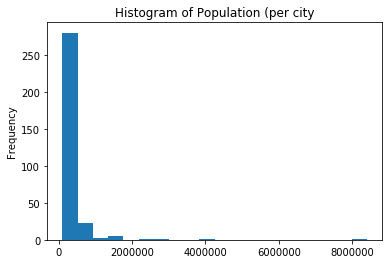

In [17]:
count, bin_edges = np.histogram(df_city['Population (Latest Estimate)'])
df_city['Population (Latest Estimate)'].plot(kind='hist', bins=20)

plt.title('Histogram of Population (per city')

plt.show()

We see that the city Jurupa Valley does not have a population figure during the census. We will update the census value and percent change accordingly.

In [18]:
df_city.sort_values(by='Percent Change', ascending=False).head()

,Population Rank,City,State,Population (Latest Estimate),Population (Latest Census),Percent Change,Land Area (sq km),Population density (sq km),Latitude,Longitude
279,280,Jurupa Valley,California,108393,0,inf,111.1,932.0,34.0026,-117.4676
169,170,Macon,Georgia,153095,91351,67.59,645.7,236.0,32.8088,-83.6942
133,134,Frisco,Texas,188170,116989,60.84,175.3,933.0,33.1554,-96.8226
237,238,Sugar Land,Texas,118600,78817,50.48,88.1,1347.0,29.5994,-95.6142
129,130,McKinney,Texas,191645,131117,46.16,163.2,1056.0,33.1985,-96.6680


In [19]:
df_city.loc[df_city['City']=='Jurupa Valley', 'Population (Latest Census)'] = df_city.loc[df_city['City']=='Jurupa Valley', 'Population (Latest Estimate)']
df_city.loc[df_city['City']=='Jurupa Valley', 'Percent Change'] = 0

We are interested in examining whether the population change is dependent on population size. From the plot and correlations below, there is no relationship.

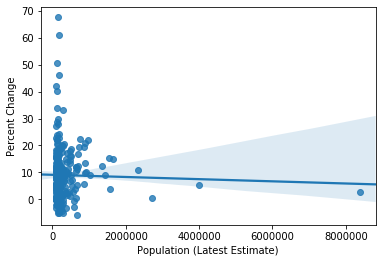

In [20]:
sns.regplot(x='Population (Latest Estimate)', y='Percent Change', data=df_city)

In [21]:
df_city[['Population (Latest Estimate)', 'Percent Change']].corr()

,Population (Latest Estimate),Percent Change
Population (Latest Estimate),1.000000,-0.025286
Percent Change,-0.025286,1.000000


Let's examine which states have the cities with the greatest population growth.

In [22]:
df_city.pivot_table(values='Percent Change', index='State', aggfunc=[np.mean, np.count_nonzero]).sort_values(by=('mean', 'Percent Change'), ascending=False)

,mean,count_nonzero
,Percent Change,Percent Change
State,,
Idaho,26.735000,2.0
North Dakota,18.280000,1.0
South Dakota,18.190000,1.0
Georgia,17.291429,7.0
District of Columbia,16.740000,1.0
Washington,16.333750,8.0
Texas,16.323000,40.0
Nevada,14.232000,5.0


The next source of data is from the U.S. Census Bureau. The census bureau provides city level data on the following categories: population characteristics, housing, education, income, and geography. One method to access this data is through a feature called QuickFacts, which provides statistics for all states and counties, and for cities and towns with a population of 5,000 or more. The user must search for a specific city to obtain the statistics for that city. Using the Python libraries requests and Beautiful Soup, we can search for each of the 300+ cities with a population of 100,000 people or more and get the statistics for each city.

In [23]:
def city_data(cities, states):
    
    cities_list = []
    
    for city, state in zip(cities, states):
        
        city_url = 'https://www.census.gov/quickfacts/fact/table/{}city{}/PST045218'.format(city.replace(' ','').lower(),state.replace(' ','').lower())
        city_source = requests.get(city_url).text
        city_soup = BeautifulSoup(city_source, 'lxml')
        city_table = city_soup.find('div', class_='qf-facttable')
        
        city_row = [city, state]
        headers = ['City', 'State']
        counter = 0
        
        for i, tag in enumerate(city_table.find_all('td')):
            if counter == 0:
                if i % 2 == 0:
                    headers.append(re.sub('[\s]', '', tag.text))
            if i % 2 != 0:
                city_row.append(re.sub('[\s,%$]', '', tag.text.replace('\ue840\ue83f','')))
        
        counter = counter + 1
        cities_list.append(city_row)
        print(city, state)
    return [cities_list, headers]

In [24]:
city_data_output = city_data(df_city['City'], df_city['State'])

New York New York
Los Angeles California
Chicago Illinois
Houston Texas
Phoenix Arizona
Philadelphia Pennsylvania
San Antonio Texas
San Diego California
Dallas Texas
San Jose California
Austin Texas
Jacksonville Florida
Fort Worth Texas
Columbus Ohio
San Francisco California
Charlotte North Carolina
Indianapolis Indiana
Seattle Washington
Denver Colorado
Washington District of Columbia
Boston Massachusetts
El Paso Texas
Detroit Michigan
Nashville Tennessee
Portland Oregon
Memphis Tennessee
Oklahoma City Oklahoma
Las Vegas Nevada
Louisville Kentucky
Baltimore Maryland
Milwaukee Wisconsin
Albuquerque New Mexico
Tucson Arizona
Fresno California
Mesa Arizona
Sacramento California
Atlanta Georgia
Kansas City Missouri
Colorado Springs Colorado
Miami Florida
Raleigh North Carolina
Omaha Nebraska
Long Beach California
Virginia Beach Virginia
Oakland California
Minneapolis Minnesota
Tulsa Oklahoma
Arlington Texas
Tampa Florida
New Orleans Louisiana
Wichita Kansas
Cleveland Ohio
Bakersfield Cali

In [25]:
df_city_data = pd.DataFrame(city_data_output[0], columns=city_data_output[1])

# Convert strings to numeric values
df_city_data[df_city_data.columns[2:]] = df_city_data.iloc[:,2:].apply(pd.to_numeric, errors='coerce')

#Remove duplicate column for column 'Populationestimates,July1,2018,(V2018)' 
df_city_data = df_city_data.loc[:,~df_city_data.columns.duplicated()]

The previous function did not work for all cities. When a city is not found, the census bureau website defaults to the statistics aggregated for the U.S. We filter the Dataframe for the population estimate of the U.S. to find the list below of cities that were not found.

In [26]:
missing_temp = df_city_data.loc[df_city_data['Populationestimates,July1,2018,(V2018)'] == 327167434][['City', 'State']]
missing_temp.reset_index(inplace=True)
missing_temp

,index,City,State
0,16,Indianapolis,Indiana
1,23,Nashville,Tennessee
2,28,Louisville,Kentucky
3,55,Honolulu,Hawaii
4,59,Lexington,Kentucky
5,62,Saint Paul,Minnesota
6,63,St. Louis,Missouri
7,67,Anchorage,Alaska
8,78,St. Petersburg,Florida
9,87,Gilbert,Arizona


We discovered that the cities were missing for the following reasons:
1. The city name did not match
2. Instead of city, the bureau classifies as balance, county, municipality

We had to manually find the correct classification for the 23 missing cities below and run the function city_data_missing to perform the remaining get requests

In [27]:
missing_city_types = ['indianapoliscitybalanceindiana',
                      'nashvilledavidsonbalancetennessee',
                      'louisvillejeffersoncountybalancekentucky',
                      'honolulucountyhawaii',
                      'lexingtonfayettekentucky',
                      'stpaulcityminnesota',
                      'stlouiscitymissouri',
                      'anchoragemunicipalityalaska',
                      'stpetersburgcityflorida',
                      'gilberttownarizona',
                      'winstonsalemcitynorthcarolina',
                      'boisecitycityidaho',
                      'augustarichmondcountybalancegeorgia',
                      'portstluciecityflorida',
                      'carytownnorthcarolina',
                      'maconbibbcountygeorgia',
                      'athensclarkecountybalancegeorgia',
                      'sanbuenaventuraventuracitycalifornia',
                      'davietownflorida',
                      'lakewoodtownshipoceancountynewjersey',
                      'clintonchartertownshipmacombcountymichigan',
                      'edisontownshipmiddlesexcountynewjersey',
                      'woodbridgetownshipmiddlesexcountynewjersey'
                     ]

In [28]:
def city_data_missing(missing):
    
    cities_list = []
    
    for city in missing:
        
        city_url = 'https://www.census.gov/quickfacts/fact/table/{}/PST045218'.format(city)
        city_source = requests.get(city_url).text
        city_soup = BeautifulSoup(city_source, 'lxml')
        city_table = city_soup.find('div', class_='qf-facttable')
        
        city_row = []
        headers = []
        counter = 0
        
        for i, tag in enumerate(city_table.find_all('td')):
            if counter == 0:
                if i % 2 == 0:
                    headers.append(re.sub('[\s]', '', tag.text))
            if i % 2 != 0:
                city_row.append(re.sub('[\s,%$]', '', tag.text.replace('\ue840\ue83f','')))
        
        counter = counter + 1
        cities_list.append(city_row)
        print(city)
    return [cities_list, headers]

In [29]:
city_data_output_missing = city_data_missing(missing_city_types)

indianapoliscitybalanceindiana
nashvilledavidsonbalancetennessee
louisvillejeffersoncountybalancekentucky
honolulucountyhawaii
lexingtonfayettekentucky
stpaulcityminnesota
stlouiscitymissouri
anchoragemunicipalityalaska
stpetersburgcityflorida
gilberttownarizona
winstonsalemcitynorthcarolina
boisecitycityidaho
augustarichmondcountybalancegeorgia
portstluciecityflorida
carytownnorthcarolina
maconbibbcountygeorgia
athensclarkecountybalancegeorgia
sanbuenaventuraventuracitycalifornia
davietownflorida
lakewoodtownshipoceancountynewjersey
clintonchartertownshipmacombcountymichigan
edisontownshipmiddlesexcountynewjersey
woodbridgetownshipmiddlesexcountynewjersey


In [30]:
# Create dataframe for the missing cities and clean the data
df_city_data_missing = pd.DataFrame(city_data_output_missing[0], columns=city_data_output_missing[1])
df_city_data_missing = df_city_data_missing.apply(pd.to_numeric, errors='coerce')
# Remove duplicate columns
df_city_data_missing = df_city_data_missing.loc[:,~df_city_data_missing.columns.duplicated()]

We update the dataframe df_city_data with the missing cities

In [31]:
df_city_data.loc[df_city_data['Populationestimates,July1,2018,(V2018)'] == 327167434] = pd.concat([missing_temp, df_city_data_missing], axis=1).set_index('index')

In [32]:
df_city_final = df_city_data

Below we have the number of cities with missing values for each statistic. We will clean up some of these statistics and drop the remaining statistics that are missing too many values

In [33]:
df_city_final.isna().sum()

City                                                                           0
State                                                                          0
Populationestimates,July1,2018,(V2018)                                         0
Populationestimatesbase,April1,2010,(V2018)                                    0
Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)        1
Population,Census,April1,2010                                                  1
Personsunder5years,percent                                                     0
Personsunder18years,percent                                                    0
Persons65yearsandover,percent                                                  0
Femalepersons,percent                                                          0
Whitealone,percent                                                             0
BlackorAfricanAmericanalone,percent(a)                                         0
AmericanIndianandAlaskaNativ

In [34]:
#Three cities dropped due to NaN values
df_city_final.drop(df_city_final[df_city_final['Totalretailsales,2012($1,000)(c)'].isna() | df_city_final['Totalretailsalespercapita,2012(c)'].isna() | df_city_final['Populationpersquaremile,2010'].isna() | df_city_final['Landareainsquaremiles,2010'].isna()].index,inplace=True)
df_city_final.reset_index(drop=True, inplace=True)

In [35]:
#Data cleaning
df_city_final.loc[179,'Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)'] = 100*(df_city_final.loc[179,'Populationestimates,July1,2018,(V2018)']/df_city_final.loc[179,'Population,Census,April1,2010']-1)
df_city_final.loc[268,['Allfirms,2012']] = 25

In [36]:
df_city_final.isna().sum()

City                                                                           0
State                                                                          0
Populationestimates,July1,2018,(V2018)                                         0
Populationestimatesbase,April1,2010,(V2018)                                    0
Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)        0
Population,Census,April1,2010                                                  0
Personsunder5years,percent                                                     0
Personsunder18years,percent                                                    0
Persons65yearsandover,percent                                                  0
Femalepersons,percent                                                          0
Whitealone,percent                                                             0
BlackorAfricanAmericanalone,percent(a)                                         0
AmericanIndianandAlaskaNativ

In [37]:
df_city_final = df_city_final.loc[:,~df_city_final.isna().any()]
df_city_final.isna().sum().sum()
df_city_final.head()

,City,State,"Populationestimates,July1,2018,(V2018)","Populationestimatesbase,April1,2010,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Population,Census,April1,2010","Personsunder5years,percent","Personsunder18years,percent","Persons65yearsandover,percent","Femalepersons,percent","Whitealone,percent","BlackorAfricanAmericanalone,percent(a)","AmericanIndianandAlaskaNativealone,percent(a)","Asianalone,percent(a)","NativeHawaiianandOtherPacificIslanderalone,percent(a)","TwoorMoreRaces,percent","HispanicorLatino,percent(b)","Whitealone,notHispanicorLatino,percent","Veterans,2013-2017","Foreignbornpersons,percent,2013-2017","Owner-occupiedhousingunitrate,2013-2017","Medianvalueofowner-occupiedhousingunits,2013-2017","Medianselectedmonthlyownercosts-withamortgage,2013-2017","Medianselectedmonthlyownercosts-withoutamortgage,2013-2017","Mediangrossrent,2013-2017","Households,2013-2017","Personsperhousehold,2013-2017","Livinginsamehouse1yearago,percentofpersonsage1year+,2013-2017","LanguageotherthanEnglishspokenathome,percentofpersonsage5years+,2013-2017","Householdswithacomputer,percent,2013-2017","HouseholdswithabroadbandInternetsubscription,percent,2013-2017","Highschoolgraduateorhigher,percentofpersonsage25years+,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Withadisability,underage65years,percent,2013-2017","Personswithouthealthinsurance,underage65years,percent","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Incivilianlaborforce,female,percentofpopulationage16years+,2013-2017","Totalretailsales,2012($1,000)(c)","Totalretailsalespercapita,2012(c)","Meantraveltimetowork(minutes),workersage16years+,2013-2017","Medianhouseholdincome(in2017dollars),2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017","Personsinpoverty,percent","Allfirms,2012","Populationpersquaremile,2010","Landareainsquaremiles,2010",FIPSCode
0,New York,New York,8398748,8174988,2.7,8175133.0,6.5,21.0,13.6,52.3,42.8,24.3,0.4,14.0,0.1,3.3,29.1,32.1,163465,37.2,32.6,538700,2588,836,1340,3142405,2.67,89.8,48.9,85.9,77.5,81.1,36.7,6.8,11.1,63.5,58.4,92265000.0,11067.0,40.8,57782,35761,19.6,1050911.0,27012.5,302.64,3651000
1,Los Angeles,California,3990456,3792820,5.2,3792621.0,6.2,21.3,11.7,50.5,52.2,8.9,0.7,11.7,0.2,3.5,48.7,28.4,88930,37.6,36.8,549800,2531,659,1302,1364227,2.83,87.3,59.6,88.0,78.3,76.4,33.0,6.3,17.2,66.3,59.6,40156864.0,10409.0,30.9,54501,31563,20.4,497999.0,8092.3,468.67,644000
2,Chicago,Illinois,2705994,2695624,0.4,2695598.0,6.6,21.5,11.7,51.5,49.1,30.5,0.3,6.2,0.0,2.6,29.0,32.7,75405,20.7,44.6,234500,1868,662,1029,1046789,2.54,84.4,36.0,83.9,73.5,83.8,37.5,7.1,14.2,66.3,61.9,22627328.0,8335.0,34.6,52497,32560,20.6,291007.0,11841.8,227.63,1714000
3,Houston,Texas,2325502,2093615,11.1,2099451.0,7.8,25.1,10.1,49.9,58.5,22.9,0.3,6.7,0.1,2.0,44.5,24.9,71749,29.2,43.3,149000,1533,511,940,838950,2.66,80.6,48.1,85.2,74.2,77.9,31.7,6.6,26.4,67.7,59.5,41589435.0,19247.0,27.0,49399,30547,21.2,260347.0,3501.5,599.59,4835000
4,Phoenix,Arizona,1660272,1446914,14.7,1445632.0,7.5,26.8,10.0,50.2,71.9,6.9,2.0,3.6,0.2,3.7,42.5,43.3,72364,19.6,53.4,197800,1373,431,954,544022,2.86,82.7,37.3,86.8,77.0,81.2,27.8,7.6,18.0,66.1,59.6,18448380.0,12392.0,25.4,52080,26528,20.9,124033.0,2797.8,516.70,455000


Let's do some data analysis on our census bureau dataframe. Let's first look at the correlations in the data set. 

We'll see which statistics are most correlated with population

In [38]:
df_city_final.corr()[['Populationestimates,July1,2018,(V2018)']].sort_values(by='Populationestimates,July1,2018,(V2018)', ascending=False)

,"Populationestimates,July1,2018,(V2018)"
"Populationestimates,July1,2018,(V2018)",1.000000
"Populationestimatesbase,April1,2010,(V2018)",0.998895
"Population,Census,April1,2010",0.998867
"Households,2013-2017",0.997735
"Allfirms,2012",0.987199
"Totalretailsales,2012($1,000)(c)",0.935995
"Veterans,2013-2017",0.840893
"Populationpersquaremile,2010",0.413386
"Landareainsquaremiles,2010",0.379576
"Meantraveltimetowork(minutes),workersage16years+,2013-2017",0.212617


Reviewing the correlations, we see that the strongest correlations are naturally with other data that is population based, notable highlights include the strong positive correlation between population and number of firms (r = .987) and total retail sales (r = .936)

Let's check if these relationships hold up if we compute the number of firms per person and number of sales per person

In [39]:
df_city_final['Firms/Person'] = df_city_final['Allfirms,2012'] / df_city_final['Populationestimates,July1,2018,(V2018)']
df_city_final['Retail Sales/Person'] = df_city_final['Totalretailsales,2012($1,000)(c)'] / df_city_final['Populationestimates,July1,2018,(V2018)']

C:\Users\btmcc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\btmcc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We see that the correlations do not hold true when considering the number of firms and retail sales per person, as expected.

In [40]:
print(df_city_final[['Populationestimates,July1,2018,(V2018)']].corrwith(df_city_final['Firms/Person']))
print(df_city_final[['Populationestimates,July1,2018,(V2018)']].corrwith(df_city_final['Retail Sales/Person']))

Populationestimates,July1,2018,(V2018)    0.136354
dtype: float64
Populationestimates,July1,2018,(V2018)   -0.098381
dtype: float64


Let's explore some specific relationships. First let's check the correlation between housing values and rent. We see that the correlation is strongly positive with r = 0.890

In [41]:
print(df_city_final[['Medianvalueofowner-occupiedhousingunits,2013-2017']].corrwith(df_city_final['Mediangrossrent,2013-2017']))

Medianvalueofowner-occupiedhousingunits,2013-2017    0.890727
dtype: float64


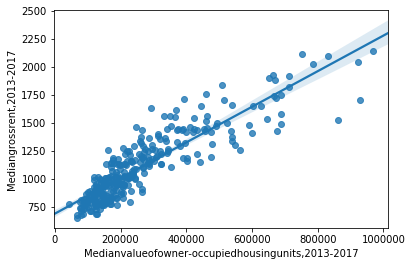

In [42]:
sns.regplot(x='Medianvalueofowner-occupiedhousingunits,2013-2017', y='Mediangrossrent,2013-2017', data=df_city_final)

Next let's check the correlation between college education and per capita income. We see that the correlation is strongly positive with r = 0.845

In [43]:
print(df_city_final[["Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017"]].corrwith(df_city_final['Percapitaincomeinpast12months(in2017dollars),2013-2017']))

Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017    0.846695
dtype: float64


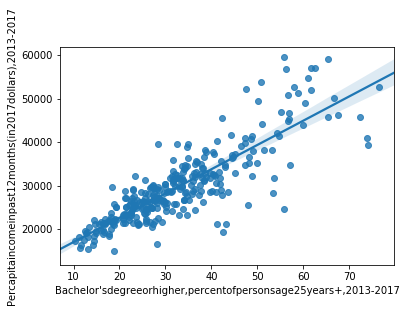

In [44]:
sns.regplot(x="Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017", y='Percapitaincomeinpast12months(in2017dollars),2013-2017', data=df_city_final)

Next let's check the correlation between college education and the employment levels. We see that the correlation is weakly positive with r = 0.454

In [45]:
print(df_city_final[["Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017"]].corrwith(df_city_final['Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017']))

Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017    0.453669
dtype: float64


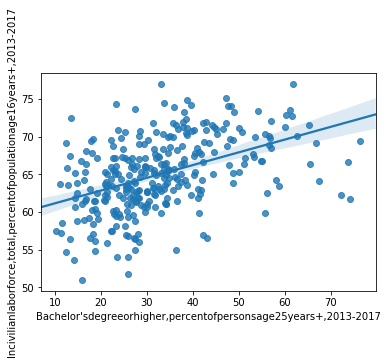

In [46]:
sns.regplot(x="Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017", y='Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017', data=df_city_final)

Next we will do some analysis on diversity:

In order to measure diversity, we will utilize Simpson's diversity index. For each city, we calculate the sum of the frequency of each population group ($p_i$) multiplied by the rareness of the group ($1-p_i$). This measure has the following appealing interpretation: pick two members of the population at random, then the diversity represents the probability that the two individuals are from different groups.

$$Diversity = \sum_{i=0}^kp_i (1-p_i)$$

In [47]:
pop = df_city_final[['BlackorAfricanAmericanalone,percent(a)', 'AmericanIndianandAlaskaNativealone,percent(a)','Asianalone,percent(a)','NativeHawaiianandOtherPacificIslanderalone,percent(a)','TwoorMoreRaces,percent','HispanicorLatino,percent(b)','Whitealone,notHispanicorLatino,percent']]
total_pop = pop.sum(axis=1)

diversity_index = []

for i in range(pop.shape[0]):
    total = total_pop[i]
    row_sum = []
    for j in range(pop.shape[1]):
        prob = pop.iat[i,j] / total
        row_sum.append(prob*(1-prob))
    diversity_index.append(sum(row_sum))
    
df_city_final['Diversity'] = diversity_index
df_city_final.head()

C:\Users\btmcc\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,City,State,"Populationestimates,July1,2018,(V2018)","Populationestimatesbase,April1,2010,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Population,Census,April1,2010","Personsunder5years,percent","Personsunder18years,percent","Persons65yearsandover,percent","Femalepersons,percent","Whitealone,percent","BlackorAfricanAmericanalone,percent(a)","AmericanIndianandAlaskaNativealone,percent(a)","Asianalone,percent(a)","NativeHawaiianandOtherPacificIslanderalone,percent(a)","TwoorMoreRaces,percent","HispanicorLatino,percent(b)","Whitealone,notHispanicorLatino,percent","Veterans,2013-2017","Foreignbornpersons,percent,2013-2017","Owner-occupiedhousingunitrate,2013-2017","Medianvalueofowner-occupiedhousingunits,2013-2017","Medianselectedmonthlyownercosts-withamortgage,2013-2017","Medianselectedmonthlyownercosts-withoutamortgage,2013-2017","Mediangrossrent,2013-2017","Households,2013-2017","Personsperhousehold,2013-2017","Livinginsamehouse1yearago,percentofpersonsage1year+,2013-2017","LanguageotherthanEnglishspokenathome,percentofpersonsage5years+,2013-2017","Householdswithacomputer,percent,2013-2017","HouseholdswithabroadbandInternetsubscription,percent,2013-2017","Highschoolgraduateorhigher,percentofpersonsage25years+,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Withadisability,underage65years,percent,2013-2017","Personswithouthealthinsurance,underage65years,percent","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Incivilianlaborforce,female,percentofpopulationage16years+,2013-2017","Totalretailsales,2012($1,000)(c)","Totalretailsalespercapita,2012(c)","Meantraveltimetowork(minutes),workersage16years+,2013-2017","Medianhouseholdincome(in2017dollars),2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017","Personsinpoverty,percent","Allfirms,2012","Populationpersquaremile,2010","Landareainsquaremiles,2010",FIPSCode,Firms/Person,Retail Sales/Person,Diversity
0,New York,New York,8398748,8174988,2.7,8175133.0,6.5,21.0,13.6,52.3,42.8,24.3,0.4,14.0,0.1,3.3,29.1,32.1,163465,37.2,32.6,538700,2588,836,1340,3142405,2.67,89.8,48.9,85.9,77.5,81.1,36.7,6.8,11.1,63.5,58.4,92265000.0,11067.0,40.8,57782,35761,19.6,1050911.0,27012.5,302.64,3651000,0.125127,10.985566,0.749340
1,Los Angeles,California,3990456,3792820,5.2,3792621.0,6.2,21.3,11.7,50.5,52.2,8.9,0.7,11.7,0.2,3.5,48.7,28.4,88930,37.6,36.8,549800,2531,659,1302,1364227,2.83,87.3,59.6,88.0,78.3,76.4,33.0,6.3,17.2,66.3,59.6,40156864.0,10409.0,30.9,54501,31563,20.4,497999.0,8092.3,468.67,644000,0.124798,10.063227,0.673158
2,Chicago,Illinois,2705994,2695624,0.4,2695598.0,6.6,21.5,11.7,51.5,49.1,30.5,0.3,6.2,0.0,2.6,29.0,32.7,75405,20.7,44.6,234500,1868,662,1029,1046789,2.54,84.4,36.0,83.9,73.5,83.8,37.5,7.1,14.2,66.3,61.9,22627328.0,8335.0,34.6,52497,32560,20.6,291007.0,11841.8,227.63,1714000,0.107542,8.361928,0.718776
3,Houston,Texas,2325502,2093615,11.1,2099451.0,7.8,25.1,10.1,49.9,58.5,22.9,0.3,6.7,0.1,2.0,44.5,24.9,71749,29.2,43.3,149000,1533,511,940,838950,2.66,80.6,48.1,85.2,74.2,77.9,31.7,6.6,26.4,67.7,59.5,41589435.0,19247.0,27.0,49399,30547,21.2,260347.0,3501.5,599.59,4835000,0.111953,17.884068,0.691337
4,Phoenix,Arizona,1660272,1446914,14.7,1445632.0,7.5,26.8,10.0,50.2,71.9,6.9,2.0,3.6,0.2,3.7,42.5,43.3,72364,19.6,53.4,197800,1373,431,954,544022,2.86,82.7,37.3,86.8,77.0,81.2,27.8,7.6,18.0,66.1,59.6,18448380.0,12392.0,25.4,52080,26528,20.9,124033.0,2797.8,516.70,455000,0.074706,11.111661,0.640067


Let's take a look at the most diverse cities:

In [48]:
df_city_final[['City','State', 'Populationestimates,July1,2018,(V2018)', 'Diversity']].sort_values(by='Diversity', ascending=False).head(10)

,City,State,"Populationestimates,July1,2018,(V2018)",Diversity
227,Vallejo,California,121913,0.784106
44,Oakland,California,429082,0.776816
241,Fairfield,California,116884,0.767171
35,Sacramento,California,508529,0.764881
77,Jersey City,New Jersey,265549,0.763639
264,Antioch,California,111535,0.763596
147,Elk Grove,California,172886,0.761015
0,New York,New York,8398748,0.749340
60,Stockton,California,311178,0.747527
55,Honolulu,Hawaii,980080,0.744785


In [49]:
df_city_final[['Diversity']].describe()

,Diversity
count,311.000000
mean,0.579153
std,0.117771
min,0.112505
25%,0.517594
50%,0.605247
75%,0.661688
max,0.784106


In [50]:
df_city_final.pivot_table(values='Diversity', index='State', aggfunc=[np.mean, np.count_nonzero]).sort_values(by=('mean', 'Diversity'), ascending=False)

,mean,count_nonzero
,Diversity,Diversity
State,,
Hawaii,0.744785,1.0
Rhode Island,0.699134,1.0
New York,0.693216,5.0
Connecticut,0.690408,5.0
Massachusetts,0.656899,5.0
District of Columbia,0.639298,1.0
Alaska,0.631761,1.0
California,0.628424,73.0


In [51]:
df_city_final[(df_city_final['State']=='Idaho') | (df_city_final['State']=='Montana') | (df_city_final['State']=='North Dakota')]

,City,State,"Populationestimates,July1,2018,(V2018)","Populationestimatesbase,April1,2010,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Population,Census,April1,2010","Personsunder5years,percent","Personsunder18years,percent","Persons65yearsandover,percent","Femalepersons,percent","Whitealone,percent","BlackorAfricanAmericanalone,percent(a)","AmericanIndianandAlaskaNativealone,percent(a)","Asianalone,percent(a)","NativeHawaiianandOtherPacificIslanderalone,percent(a)","TwoorMoreRaces,percent","HispanicorLatino,percent(b)","Whitealone,notHispanicorLatino,percent","Veterans,2013-2017","Foreignbornpersons,percent,2013-2017","Owner-occupiedhousingunitrate,2013-2017","Medianvalueofowner-occupiedhousingunits,2013-2017","Medianselectedmonthlyownercosts-withamortgage,2013-2017","Medianselectedmonthlyownercosts-withoutamortgage,2013-2017","Mediangrossrent,2013-2017","Households,2013-2017","Personsperhousehold,2013-2017","Livinginsamehouse1yearago,percentofpersonsage1year+,2013-2017","LanguageotherthanEnglishspokenathome,percentofpersonsage5years+,2013-2017","Householdswithacomputer,percent,2013-2017","HouseholdswithabroadbandInternetsubscription,percent,2013-2017","Highschoolgraduateorhigher,percentofpersonsage25years+,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Withadisability,underage65years,percent,2013-2017","Personswithouthealthinsurance,underage65years,percent","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Incivilianlaborforce,female,percentofpopulationage16years+,2013-2017","Totalretailsales,2012($1,000)(c)","Totalretailsalespercapita,2012(c)","Meantraveltimetowork(minutes),workersage16years+,2013-2017","Medianhouseholdincome(in2017dollars),2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017","Personsinpoverty,percent","Allfirms,2012","Populationpersquaremile,2010","Landareainsquaremiles,2010",FIPSCode,Firms/Person,Retail Sales/Person,Diversity
95,Boise,Idaho,246328,229634,7.3,229617.0,6.7,23.9,13.7,53.0,56.2,34.7,0.3,2.2,0.1,2.3,14.9,45.9,13962,9.8,54.5,142200,1141,409,765,94105,2.45,81.8,17.1,85.4,75.5,86.8,34.1,7.1,15.5,61.1,56.6,4067779.0,17358.0,20.6,42219,26668,23.3,18681.0,1733.6,132.45,3775000,0.075838,16.513669,0.648504
219,Fargo,North Dakota,124844,105610,18.2,105549.0,6.9,20.1,11.1,49.4,86.2,5.5,1.1,3.6,0.0,2.9,2.8,84.5,5984,8.2,43.4,190200,1383,504,765,52751,2.14,72.7,9.4,90.1,80.6,93.8,38.8,7.3,8.5,74.8,71.4,3299921.0,30060.0,15.0,50561,31866,13.9,11347.0,2162.0,48.82,3825700,0.090889,26.432356,0.285634
273,Billings,Montana,109550,104294,5.0,104170.0,6.5,22.9,16.2,51.5,90.1,0.9,4.4,0.6,0.1,3.0,6.3,85.5,8073,2.4,62.9,206100,1374,439,826,45722,2.32,81.4,3.8,88.6,80.4,92.9,32.6,9.1,12.7,67.3,61.8,2761842.0,25823.0,16.7,55585,31854,10.8,11376.0,2399.5,43.41,3006550,0.103843,25.210790,0.273719
283,Meridian,Idaho,106804,76959,38.8,75092.0,7.6,28.7,12.0,51.0,93.6,0.8,0.2,2.3,0.2,1.8,6.6,88.5,5224,5.4,76.2,221300,1381,349,1016,33201,2.76,85.7,6.5,91.8,77.9,95.6,33.7,4.9,10.1,65.7,58.7,1648578.0,20508.0,22.2,64375,29857,9.8,7855.0,2802.8,26.79,1652120,0.073546,15.435545,0.217764


An important consideration for choosing a city is the number of activities available for its residents, for example the number of Arts and Entertainment venues in a city. To retrieve this data, we use the Foursquare API called Places. The Places API offers real-time access to Foursquare’s global database of rich venue data. Ideally, we would extract all venues from the Foursquare database to understand the number of venues available in a city, but we are only limited to 100 venues per API call. Extracting all venues from Foursquare would require searching each possible latitude and longitude in a specific city. As an approximation to extracting all venues, we use the Foursquare Explore endpoint to get the top 100 recommended venues for each city in our list. If Arts and Entertainment venues are more likely to be recommended in one city versus another, then we assume that the city with the higher recommendations has relatively more Arts and Entertainment venues then the other city

First we write a function so we can make the Foursquare API calls for each city

In [52]:
errors = []
def getRecommendedVenues(cities, states):
    
    venues_list=[]
    
    for city, state in zip(cities, states):
        print(city, state)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}, {}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            city, 
            state, 
            100000)
        
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([( 
                city, 
                state, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        
        except:
            errors.append([city, state])
    rec_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    rec_venues.columns = ['City', 
                  'State',  
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(rec_venues)

We make the Foursquare API calls for all cities

In [53]:
city_venues = getRecommendedVenues(df_city_final['City'],df_city_final['State'])

New York New York
Los Angeles California
Chicago Illinois
Houston Texas
Phoenix Arizona
Philadelphia Pennsylvania
San Antonio Texas
San Diego California
Dallas Texas
San Jose California
Austin Texas
Jacksonville Florida
Fort Worth Texas
Columbus Ohio
San Francisco California
Charlotte North Carolina
Indianapolis Indiana
Seattle Washington
Denver Colorado
Washington District of Columbia
Boston Massachusetts
El Paso Texas
Detroit Michigan
Nashville Tennessee
Portland Oregon
Memphis Tennessee
Oklahoma City Oklahoma
Las Vegas Nevada
Louisville Kentucky
Baltimore Maryland
Milwaukee Wisconsin
Albuquerque New Mexico
Tucson Arizona
Fresno California
Mesa Arizona
Sacramento California
Atlanta Georgia
Kansas City Missouri
Colorado Springs Colorado
Miami Florida
Raleigh North Carolina
Omaha Nebraska
Long Beach California
Virginia Beach Virginia
Oakland California
Minneapolis Minnesota
Tulsa Oklahoma
Arlington Texas
Tampa Florida
New Orleans Louisiana
Wichita Kansas
Cleveland Ohio
Bakersfield Cali

The API calls were unsuccessful for 2 cities, so we make the API call again for these 2 cities and add them to the city_venues dataframe 

In [54]:
# Check to see which cities are missing from city_venues
city_missing_venue = df_city_final.loc[~df_city_final['City'].isin(city_venues['City'])]
city_missing_venue

,City,State,"Populationestimates,July1,2018,(V2018)","Populationestimatesbase,April1,2010,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Population,Census,April1,2010","Personsunder5years,percent","Personsunder18years,percent","Persons65yearsandover,percent","Femalepersons,percent","Whitealone,percent","BlackorAfricanAmericanalone,percent(a)","AmericanIndianandAlaskaNativealone,percent(a)","Asianalone,percent(a)","NativeHawaiianandOtherPacificIslanderalone,percent(a)","TwoorMoreRaces,percent","HispanicorLatino,percent(b)","Whitealone,notHispanicorLatino,percent","Veterans,2013-2017","Foreignbornpersons,percent,2013-2017","Owner-occupiedhousingunitrate,2013-2017","Medianvalueofowner-occupiedhousingunits,2013-2017","Medianselectedmonthlyownercosts-withamortgage,2013-2017","Medianselectedmonthlyownercosts-withoutamortgage,2013-2017","Mediangrossrent,2013-2017","Households,2013-2017","Personsperhousehold,2013-2017","Livinginsamehouse1yearago,percentofpersonsage1year+,2013-2017","LanguageotherthanEnglishspokenathome,percentofpersonsage5years+,2013-2017","Householdswithacomputer,percent,2013-2017","HouseholdswithabroadbandInternetsubscription,percent,2013-2017","Highschoolgraduateorhigher,percentofpersonsage25years+,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Withadisability,underage65years,percent,2013-2017","Personswithouthealthinsurance,underage65years,percent","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Incivilianlaborforce,female,percentofpopulationage16years+,2013-2017","Totalretailsales,2012($1,000)(c)","Totalretailsalespercapita,2012(c)","Meantraveltimetowork(minutes),workersage16years+,2013-2017","Medianhouseholdincome(in2017dollars),2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017","Personsinpoverty,percent","Allfirms,2012","Populationpersquaremile,2010","Landareainsquaremiles,2010",FIPSCode,Firms/Person,Retail Sales/Person,Diversity
295,Burbank,California,103695,103358,0.3,103340.0,5.7,18.9,15.1,52.1,70.7,2.8,0.5,11.7,0.0,5.0,24.5,56.7,3855,32.9,41.0,646000,2694,542,1539,41664,2.5,88.3,45.8,91.1,85.5,89.9,40.3,5.9,11.4,67.4,62.6,2316763.0,22193.0,27.8,69118,37767,11.3,17587.0,5959.3,17.34,608954,0.169603,22.34209,0.610883


In [55]:
city_venues_missing = getRecommendedVenues(city_missing_venue['City'],city_missing_venue['State'])

Burbank California


In [56]:
city_venues_final = pd.concat([city_venues, city_venues_missing], axis=0, ignore_index=True)

In [57]:
# Confirm all cities are captured in the final venue dataframe
city_venues_final.groupby(['City', 'State']).count().shape[0]

311

In [58]:
city_venues_final.head()

,City,State,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York,New York,Central Park,40.784083,-73.964853,Park
1,New York,New York,Brooklyn Bridge Park,40.702282,-73.996456,Park
2,New York,New York,Los Tacos No. 1,40.757134,-73.987536,Taco Place
3,New York,New York,Hudson River Greenway Running Path,40.732552,-74.010580,Trail
4,New York,New York,The Metropolitan Museum of Art (Metropolitan M...,40.779729,-73.963416,Art Museum


We now take the individual venues and classify them by their high level venue cateogry

In [59]:
# Classify venues by venue category
city_venue_cat = city_venues_final.merge(df_categories, left_on='Venue Category', right_on='Venue')

In [60]:
city_venue_cat.head()

,City,State,Venue_x,Venue Latitude,Venue Longitude,Venue Category_x,Venue Category_y,Venue_y
0,New York,New York,Central Park,40.784083,-73.964853,Park,Outdoors & Recreation,Park
1,New York,New York,Brooklyn Bridge Park,40.702282,-73.996456,Park,Outdoors & Recreation,Park
2,New York,New York,Hudson River Park,40.733217,-74.010494,Park,Outdoors & Recreation,Park
3,New York,New York,Bryant Park,40.753621,-73.983265,Park,Outdoors & Recreation,Park
4,New York,New York,High Line,40.746825,-74.005507,Park,Outdoors & Recreation,Park


In [61]:
city_venue_cat.rename(columns={'Venue Category_y':'Venue Category'}, inplace=True)
city_venue_cat = city_venue_cat[['City', 'State', 'Venue Category']]
city_venue_cat.head()

,City,State,Venue Category
0,New York,New York,Outdoors & Recreation
1,New York,New York,Outdoors & Recreation
2,New York,New York,Outdoors & Recreation
3,New York,New York,Outdoors & Recreation
4,New York,New York,Outdoors & Recreation


In [62]:
city_venue_cat['Venue Category'].value_counts()

Food                           16819
Shop & Service                  6080
Outdoors & Recreation           3149
Arts & Entertainment            1916
Nightlife Spot                  1882
Travel & Transport               526
Professional & Other Places      190
College & University              94
Residence                          5
Event                              2
Name: Venue Category, dtype: int64

We use one hot encoding to calculate the relative frequency of each of the high level categories per city

In [63]:
# one hot encoding
venue_onehot = pd.get_dummies(city_venue_cat[['Venue Category']], prefix='', prefix_sep='')
df_city_venue_cat = pd.concat([city_venue_cat[['City', 'State']], venue_onehot], axis=1)
df_city_venue_cat.head()

,City,State,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,New York,New York,0,0,0,0,0,1,0,0,0,0
1,New York,New York,0,0,0,0,0,1,0,0,0,0
2,New York,New York,0,0,0,0,0,1,0,0,0,0
3,New York,New York,0,0,0,0,0,1,0,0,0,0
4,New York,New York,0,0,0,0,0,1,0,0,0,0


In [64]:
df_city_venue_grouped = df_city_venue_cat.groupby(['City', 'State']).mean().reset_index()
df_city_venue_grouped.head()

,City,State,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Abilene,Texas,0.053191,0.00,0.0,0.702128,0.021277,0.00,0.00,0.0,0.191489,0.031915
1,Akron,Ohio,0.110000,0.00,0.0,0.510000,0.100000,0.12,0.01,0.0,0.150000,0.000000
2,Albuquerque,New Mexico,0.090000,0.01,0.0,0.520000,0.080000,0.07,0.01,0.0,0.190000,0.030000
3,Alexandria,Virginia,0.040000,0.00,0.0,0.450000,0.030000,0.21,0.01,0.0,0.240000,0.020000
4,Allen,Texas,0.040000,0.00,0.0,0.580000,0.030000,0.10,0.00,0.0,0.240000,0.010000


We include the census bureau statistics that are factors in the decision to decide which city to live in

In [65]:
df_final = df_city_venue_grouped.merge(df_city_final[['City',
 'State',
 'Populationestimates,July1,2018,(V2018)',
 'Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)',
 'Mediangrossrent,2013-2017',
 "Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017",
 'Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017',
 'Percapitaincomeinpast12months(in2017dollars),2013-2017',
 'Diversity',
 'Landareainsquaremiles,2010'
]])

Let's do some further analysis on our venue frequencies:

In [66]:
df_final.sort_values(by='Outdoors & Recreation', ascending=False).head(10)

,City,State,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,"Populationestimates,July1,2018,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Mediangrossrent,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017",Diversity,"Landareainsquaremiles,2010"
181,New York,New York,0.23,0.00,0.0,0.11,0.01,0.46,0.04,0.0,0.12,0.03,8398748,2.7,1340,36.7,63.5,35761,0.749340,302.64
243,San Francisco,California,0.16,0.00,0.0,0.16,0.05,0.39,0.00,0.0,0.24,0.00,883305,9.7,1709,55.8,70.3,59508,0.696883,46.87
242,San Diego,California,0.13,0.00,0.0,0.22,0.09,0.36,0.01,0.0,0.14,0.05,1425976,9.5,1503,44.4,65.0,37112,0.702519,325.19
152,Los Angeles,California,0.22,0.01,0.0,0.22,0.02,0.33,0.01,0.0,0.16,0.03,3990456,5.2,1302,33.0,66.3,31563,0.673158,468.67
119,Honolulu,Hawaii,0.05,0.00,0.0,0.45,0.04,0.29,0.00,0.0,0.07,0.10,980080,2.8,1653,34.0,61.2,33776,0.744785,600.74
254,Seattle,Washington,0.10,0.00,0.0,0.30,0.12,0.28,0.01,0.0,0.18,0.01,744955,22.4,1377,61.7,72.7,51872,0.547978,83.94
28,Boulder,Colorado,0.03,0.02,0.0,0.45,0.12,0.26,0.00,0.0,0.10,0.02,107353,9.9,1412,73.8,66.6,40895,0.339041,24.66
46,Chicago,Illinois,0.15,0.00,0.0,0.33,0.04,0.24,0.01,0.0,0.16,0.07,2705994,0.4,1029,37.5,66.3,32560,0.718776,227.63
13,Atlanta,Georgia,0.14,0.00,0.0,0.41,0.06,0.24,0.00,0.0,0.13,0.02,498044,16.7,1037,48.7,65.2,40595,0.589679,133.15
27,Boston,Massachusetts,0.12,0.00,0.0,0.41,0.08,0.23,0.02,0.0,0.11,0.03,694583,12.4,1445,47.4,68.8,39686,0.711278,48.28


In [67]:
df_final.sort_values(by='Arts & Entertainment', ascending=False).head(10)

,City,State,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,"Populationestimates,July1,2018,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Mediangrossrent,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017",Diversity,"Landareainsquaremiles,2010"
7,Anaheim,California,0.44,0.00,0.0,0.25,0.11,0.05,0.00,0.0,0.13,0.02,352005,4.6,1469,25.3,67.2,26185,0.632958,49.84
197,Orlando,Florida,0.35,0.00,0.0,0.32,0.02,0.02,0.00,0.0,0.22,0.07,285713,19.6,1091,35.8,71.8,28117,0.703572,102.40
145,Las Vegas,Nevada,0.25,0.00,0.0,0.27,0.04,0.15,0.01,0.0,0.20,0.08,644644,10.3,1024,23.2,63.2,27650,0.688037,135.82
51,Cleveland,Ohio,0.23,0.00,0.0,0.48,0.12,0.06,0.00,0.0,0.10,0.01,383793,-3.2,678,16.4,58.9,18844,0.631997,77.70
181,New York,New York,0.23,0.00,0.0,0.11,0.01,0.46,0.04,0.0,0.12,0.03,8398748,2.7,1340,36.7,63.5,35761,0.749340,302.64
152,Los Angeles,California,0.22,0.01,0.0,0.22,0.02,0.33,0.01,0.0,0.16,0.03,3990456,5.2,1302,33.0,66.3,31563,0.673158,468.67
161,Memphis,Tennessee,0.19,0.00,0.0,0.45,0.07,0.15,0.00,0.0,0.12,0.02,650618,-0.2,862,25.4,63.5,23629,0.521974,315.06
132,Kansas City,Kansas,0.18,0.00,0.0,0.52,0.08,0.03,0.02,0.0,0.16,0.01,152958,4.9,820,16.5,65.3,19833,0.709948,124.81
297,Washington,District of Columbia,0.18,0.00,0.0,0.34,0.06,0.16,0.11,0.0,0.12,0.03,702455,16.7,1424,56.6,68.9,50832,0.639298,61.05
194,Omaha,Nebraska,0.18,0.01,0.0,0.50,0.06,0.10,0.00,0.0,0.15,0.00,468262,4.0,861,35.6,69.9,30222,0.515446,127.09


In [68]:
df_final.corr()[['Populationestimates,July1,2018,(V2018)']].sort_values(by='Populationestimates,July1,2018,(V2018)',ascending=False)

,"Populationestimates,July1,2018,(V2018)"
"Populationestimates,July1,2018,(V2018)",1.000000
Outdoors & Recreation,0.543713
Arts & Entertainment,0.392537
"Landareainsquaremiles,2010",0.379576
Travel & Transport,0.219685
Professional & Other Places,0.184482
Diversity,0.171702
"Percapitaincomeinpast12months(in2017dollars),2013-2017",0.066444
"Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017",0.041166
"Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017",0.031230


In [69]:
df_cluster = df_final.drop(['City','State'], axis=1)
df_cluster.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,"Populationestimates,July1,2018,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Mediangrossrent,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017",Diversity,"Landareainsquaremiles,2010"
0,0.053191,0.00,0.0,0.702128,0.021277,0.00,0.00,0.0,0.191489,0.031915,122999,4.7,846,22.1,57.5,22819,0.588869,106.79
1,0.110000,0.00,0.0,0.510000,0.100000,0.12,0.01,0.0,0.150000,0.000000,198006,-0.6,713,20.8,62.3,22416,0.559842,62.03
2,0.090000,0.01,0.0,0.520000,0.080000,0.07,0.01,0.0,0.190000,0.030000,560218,2.6,833,34.3,63.8,28229,0.624372,187.73
3,0.040000,0.00,0.0,0.450000,0.030000,0.21,0.01,0.0,0.240000,0.020000,160530,14.7,1663,61.8,76.9,57019,0.660529,15.03
4,0.040000,0.00,0.0,0.580000,0.030000,0.10,0.00,0.0,0.240000,0.010000,103383,22.7,1374,54.3,73.4,42098,0.589132,26.29


We use k-means clustering to cluster the cities into different groups.

In [112]:
X = StandardScaler().fit_transform(df_cluster)

kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=123).fit(X)

In [118]:
df_cluster['Cluster'] = kmeans.labels_
df_cluster.groupby('Cluster').mean()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,"Populationestimates,July1,2018,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Mediangrossrent,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017",Diversity,"Landareainsquaremiles,2010"
Cluster,,,,,,,,,,,,,,,,,,
0,0.057029,0.000769,0.000000,0.518173,0.054685,0.138497,0.009702,0.000308,0.203948,0.016889,2.675492e+05,14.111138,1437.630769,49.550769,69.181538,42364.261538,0.605187,60.418308
1,0.076007,0.007413,0.000182,0.552188,0.090999,0.091014,0.006021,0.000273,0.157121,0.018781,2.367800e+05,5.337273,880.272727,31.642727,63.777273,26340.009091,0.546035,88.175000
2,0.034699,0.000431,0.000000,0.590206,0.035246,0.079476,0.004213,0.000000,0.243650,0.012080,1.713421e+05,8.052586,1146.836207,24.499138,63.629310,25752.965517,0.583763,59.779914
3,0.162000,0.001500,0.000000,0.388500,0.066500,0.178500,0.007000,0.000000,0.158000,0.038000,1.594108e+06,7.745000,1082.250000,31.390000,65.800000,29748.400000,0.649955,439.986500


## Results and Discussion <a name="results"></a>

Cluster 0 - Medium Population; Some Activities; High growth; High rent; High education; High income  
Cluster 1 - Medium Population; Some Activities; Lower rent; Less diversity  
Cluster 2 - Lower Population; Less Activities; Less educated; Higher rent with lower income  
Cluster 3 - High Population; Lots of Activities; Greater diversity; reasonable rent; larger land area    

In [119]:
df_final['Cluster'] = kmeans.labels_
df_viz = df_final.merge(df_city[[
    'City',
    'State',
    'Latitude',
    'Longitude'
]])
df_viz.head()

,City,State,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,"Populationestimates,July1,2018,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Mediangrossrent,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017",Diversity,"Landareainsquaremiles,2010",Cluster,Latitude,Longitude
0,Abilene,Texas,0.053191,0.00,0.0,0.702128,0.021277,0.00,0.00,0.0,0.191489,0.031915,122999,4.7,846,22.1,57.5,22819,0.588869,106.79,2,32.4545,-99.7381
1,Akron,Ohio,0.110000,0.00,0.0,0.510000,0.100000,0.12,0.01,0.0,0.150000,0.000000,198006,-0.6,713,20.8,62.3,22416,0.559842,62.03,1,41.0805,-81.5214
2,Albuquerque,New Mexico,0.090000,0.01,0.0,0.520000,0.080000,0.07,0.01,0.0,0.190000,0.030000,560218,2.6,833,34.3,63.8,28229,0.624372,187.73,1,35.1056,-106.6474
3,Alexandria,Virginia,0.040000,0.00,0.0,0.450000,0.030000,0.21,0.01,0.0,0.240000,0.020000,160530,14.7,1663,61.8,76.9,57019,0.660529,15.03,0,38.8201,-77.0841
4,Allen,Texas,0.040000,0.00,0.0,0.580000,0.030000,0.10,0.00,0.0,0.240000,0.010000,103383,22.7,1374,54.3,73.4,42098,0.589132,26.29,0,33.0997,-96.6631


In [120]:
# create map
map_clusters = folium.Map(location=[39.8283, -98.5795], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_viz['Latitude'], df_viz['Longitude'], df_viz['City'], df_viz['Cluster']):
    label = folium.Popup(poi + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [116]:
df_final['Cluster'].value_counts()

2    116
1    110
0     65
3     20
Name: Cluster, dtype: int64

In our analysis we were able to identify cities that were most likely the least attractive cities to move to. It appears that Cluster 2 cities are the least attractive, with less activities, less educated population, and higher rent with lower income. Cluster 2 cities had the highest value counts among the clusters. The states with the highest proportion of Cluster 2 cities are California, Virginia, and Florida, where California cities with 100k+ having 62% of these cities in Cluster 2. For California, we see the Cluster 2 cities in the following areas: East Bay (Northern California), Central California, and the greater Los Angeles Area (especially east of LA proper). For Florida, the concentration of Cluster 2 cities is in the South and for Virginia, it’s near the East Coast.

In [121]:
counts = pd.DataFrame(df_final.groupby('State')['Cluster'].value_counts(normalize=True))
counts.columns = ['Proportion']
counts.reset_index(inplace=True)

In [123]:
counts[counts['Cluster']==2].sort_values(by='Proportion',ascending=False).head()

,State,Cluster,Proportion
7,California,2,0.616438
90,Virginia,2,0.571429
18,Florida,2,0.545455
89,Utah,2,0.500000
27,Idaho,2,0.500000


The next cluster that is likely more attractive than Cluster 2 cities is Cluster 1. Cluster 1 has a lower rent with similar income levels as Cluster 2 cities, and on average there are more activities to do in these cities. Cluster 1 cities are predominantly in the Midwest and Southern states, where rent is generally lower than the West and East coast cities. Some of the higher populated cities of Cluster 1 include Detroit, Baltimore, and Milwaukee.

In [128]:
df_final[df_final['Cluster']==1].sort_values(by='Populationestimates,July1,2018,(V2018)',ascending=False).head(10)

,City,State,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,"Populationestimates,July1,2018,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Mediangrossrent,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017",Diversity,"Landareainsquaremiles,2010",Cluster
94,Fort Worth,Texas,0.07,0.01,0.0,0.52,0.06,0.10,0.00,0.0,0.22,0.02,895008,20.2,967,28.3,67.0,27191,0.689277,339.82,1
59,Columbus,Ohio,0.07,0.00,0.0,0.56,0.07,0.11,0.00,0.0,0.17,0.02,892533,13.1,889,35.1,70.1,26778,0.594182,217.17,1
79,El Paso,Texas,0.06,0.01,0.0,0.53,0.12,0.03,0.00,0.0,0.24,0.01,682669,5.3,792,24.1,59.3,21120,0.358133,255.24,1
73,Detroit,Michigan,0.17,0.00,0.0,0.43,0.09,0.12,0.02,0.0,0.12,0.05,672662,-5.8,773,14.2,53.6,16433,0.361981,138.75,1
19,Baltimore,Maryland,0.10,0.00,0.0,0.53,0.12,0.09,0.00,0.0,0.13,0.03,602495,-3.0,1009,30.4,61.4,28488,0.531366,80.94,1
168,Milwaukee,Wisconsin,0.08,0.00,0.0,0.44,0.13,0.13,0.01,0.0,0.16,0.05,592025,-0.4,822,23.8,65.0,21627,0.692798,96.12,1
2,Albuquerque,New Mexico,0.09,0.01,0.0,0.52,0.08,0.07,0.01,0.0,0.19,0.03,560218,2.6,833,34.3,63.8,28229,0.624372,187.73,1
283,Tucson,Arizona,0.06,0.03,0.0,0.51,0.07,0.10,0.00,0.0,0.17,0.06,545975,3.7,801,26.6,60.9,21684,0.638474,226.71,1
133,Kansas City,Missouri,0.17,0.00,0.0,0.50,0.09,0.04,0.02,0.0,0.17,0.01,491918,7.0,862,33.5,68.3,29742,0.605247,314.95,1
55,Colorado Springs,Colorado,0.04,0.00,0.0,0.46,0.12,0.17,0.00,0.0,0.16,0.05,472688,13.2,1013,38.4,64.2,31333,0.510690,194.54,1


The final two clusters of our model both have attractive features. We recommend that the stakeholder use the cities from these two clusters as a starting point in diving deeper into U.S. cities with population greater than 100k, to decide which city to move. We start first with discussing Cluster 0 cities. Cluster 0 is very attractive in that these cities are on average experiencing greater population growth, with higher per capita incomes and a more educated population. But with these, Cluster 0 is facing higher rents -> higher cost of living.  

Of the Cluster 0 cities, the highest rents of the country are happening in California, especially in Northern California in Silicon Valley. On the other hand, the highest per capita income paints a slightly different picture, where we see cities in Washington, Virginia, and Arizona, among others, experiencing higher incomes.  

Cluster 3 cities are notable for their population size. Cluster 3 contains 9 of the top 10 most populous cities in the U.S. These large urban cities offer the most activities for their residents and have more diversity. The rent is more reasonable compared to Cluster 0 cities, but the per capita incomes are lower as well.  

In [131]:
df_final[df_final['Cluster']==0].sort_values(by='Mediangrossrent,2013-2017',ascending=False).head(10)

,City,State,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,"Populationestimates,July1,2018,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Mediangrossrent,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017",Diversity,"Landareainsquaremiles,2010",Cluster
270,Sunnyvale,California,0.030000,0.0,0.0,0.590000,0.020000,0.220000,0.000000,0.0,0.110000,0.030000,153185,9.4,2147,62.6,70.1,56968,0.667509,21.99,0
126,Irvine,California,0.020000,0.0,0.0,0.640000,0.010000,0.130000,0.010000,0.0,0.170000,0.020000,282572,33.3,2114,67.5,64.1,46246,0.644475,66.11,0
248,Santa Clara,California,0.060000,0.0,0.0,0.540000,0.010000,0.100000,0.010000,0.0,0.270000,0.010000,129488,11.2,2096,57.0,68.5,46793,0.693956,18.41,0
245,San Mateo,California,0.030000,0.0,0.0,0.540000,0.040000,0.180000,0.010000,0.0,0.200000,0.000000,105025,8.0,2041,50.7,70.6,53808,0.702861,12.13,0
95,Fremont,California,0.050000,0.0,0.0,0.560000,0.010000,0.210000,0.010000,0.0,0.150000,0.010000,237807,11.1,2028,55.1,66.7,47015,0.618328,77.46,0
279,Thousand Oaks,California,0.060000,0.0,0.0,0.550000,0.000000,0.190000,0.000000,0.0,0.200000,0.000000,127690,1.0,1925,50.1,65.3,49493,0.505911,55.03,0
36,Carlsbad,California,0.080000,0.0,0.0,0.470000,0.030000,0.170000,0.000000,0.0,0.190000,0.060000,115877,10.0,1918,58.1,64.2,52560,0.442926,37.72,0
66,Daly City,California,0.021277,0.0,0.0,0.574468,0.031915,0.106383,0.010638,0.0,0.244681,0.010638,107008,5.8,1899,36.5,68.2,31889,0.619625,7.66,0
34,Cambridge,Massachusetts,0.130000,0.0,0.0,0.550000,0.070000,0.090000,0.010000,0.0,0.130000,0.020000,118977,13.1,1880,76.5,69.4,52552,0.586380,6.39,0
256,Simi Valley,California,0.050000,0.0,0.0,0.560000,0.010000,0.110000,0.020000,0.0,0.250000,0.000000,125851,1.3,1837,32.5,67.4,39452,0.577481,41.48,0


In [132]:
df_final[df_final['Cluster']==0].sort_values(by='Percapitaincomeinpast12months(in2017dollars),2013-2017',ascending=False).head(10)

,City,State,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,"Populationestimates,July1,2018,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Mediangrossrent,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017",Diversity,"Landareainsquaremiles,2010",Cluster
243,San Francisco,California,0.16,0.0,0.0,0.16,0.05,0.39,0.00,0.0,0.24,0.00,883305,9.7,1709,55.8,70.3,59508,0.696883,46.87,0
22,Bellevue,Washington,0.03,0.0,0.0,0.40,0.05,0.17,0.00,0.0,0.34,0.01,147599,15.4,1741,65.5,66.3,59007,0.618637,31.97,0
3,Alexandria,Virginia,0.04,0.0,0.0,0.45,0.03,0.21,0.01,0.0,0.24,0.02,160530,14.7,1663,61.8,76.9,57019,0.660529,15.03,0
270,Sunnyvale,California,0.03,0.0,0.0,0.59,0.02,0.22,0.00,0.0,0.11,0.03,153185,9.4,2147,62.6,70.1,56968,0.667509,21.99,0
253,Scottsdale,Arizona,0.05,0.0,0.0,0.48,0.04,0.18,0.01,0.0,0.17,0.07,255310,17.4,1221,56.2,62.5,56794,0.338504,183.92,0
246,Sandy Springs,Georgia,0.02,0.0,0.0,0.49,0.02,0.11,0.00,0.0,0.35,0.01,108797,16.0,1154,61.1,73.5,54837,0.630207,37.64,0
245,San Mateo,California,0.03,0.0,0.0,0.54,0.04,0.18,0.01,0.0,0.20,0.00,105025,8.0,2041,50.7,70.6,53808,0.702861,12.13,0
36,Carlsbad,California,0.08,0.0,0.0,0.47,0.03,0.17,0.00,0.0,0.19,0.06,115877,10.0,1918,58.1,64.2,52560,0.442926,37.72,0
34,Cambridge,Massachusetts,0.13,0.0,0.0,0.55,0.07,0.09,0.01,0.0,0.13,0.02,118977,13.1,1880,76.5,69.4,52552,0.586380,6.39,0
266,Stamford,Connecticut,0.04,0.0,0.0,0.58,0.07,0.12,0.01,0.0,0.18,0.00,129775,5.8,1704,47.6,74.1,52245,0.670875,37.64,0


In [135]:
df_final.sort_values(by='Populationestimates,July1,2018,(V2018)',ascending=False).head(10)

,City,State,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,"Populationestimates,July1,2018,(V2018)","Population,percentchange-April1,2010(estimatesbase)toJuly1,2018,(V2018)","Mediangrossrent,2013-2017","Bachelor'sdegreeorhigher,percentofpersonsage25years+,2013-2017","Incivilianlaborforce,total,percentofpopulationage16years+,2013-2017","Percapitaincomeinpast12months(in2017dollars),2013-2017",Diversity,"Landareainsquaremiles,2010",Cluster
181,New York,New York,0.23,0.00,0.0,0.11,0.01,0.46,0.04,0.0,0.12,0.03,8398748,2.7,1340,36.7,63.5,35761,0.749340,302.64,3
152,Los Angeles,California,0.22,0.01,0.0,0.22,0.02,0.33,0.01,0.0,0.16,0.03,3990456,5.2,1302,33.0,66.3,31563,0.673158,468.67,3
46,Chicago,Illinois,0.15,0.00,0.0,0.33,0.04,0.24,0.01,0.0,0.16,0.07,2705994,0.4,1029,37.5,66.3,32560,0.718776,227.63,3
120,Houston,Texas,0.13,0.00,0.0,0.38,0.09,0.20,0.00,0.0,0.17,0.03,2325502,11.1,940,31.7,67.7,30547,0.691337,599.59,3
210,Phoenix,Arizona,0.10,0.00,0.0,0.45,0.07,0.16,0.00,0.0,0.17,0.05,1660272,14.7,954,27.8,66.1,26528,0.640067,516.70,3
209,Philadelphia,Pennsylvania,0.10,0.00,0.0,0.46,0.07,0.23,0.01,0.0,0.10,0.03,1584138,3.8,970,27.1,59.6,24811,0.683775,134.10,3
240,San Antonio,Texas,0.10,0.00,0.0,0.44,0.06,0.11,0.03,0.0,0.24,0.02,1532233,15.5,918,25.7,63.5,24325,0.542288,460.93,3
242,San Diego,California,0.13,0.00,0.0,0.22,0.09,0.36,0.01,0.0,0.14,0.05,1425976,9.5,1503,44.4,65.0,37112,0.702519,325.19,3
65,Dallas,Texas,0.15,0.00,0.0,0.39,0.07,0.14,0.00,0.0,0.21,0.04,1345047,12.3,937,31.6,68.3,31260,0.689300,340.52,3
244,San Jose,California,0.05,0.00,0.0,0.54,0.05,0.14,0.01,0.0,0.21,0.00,1030119,8.2,1822,41.3,67.9,40275,0.716315,176.53,0


## Conclusion <a name="conclusion"></a>

The purpose of this project was to group U.S. cities with population greater than 100,000 people into different clusters, with the intention of highlighting potential cities for stakeholders to move and live. We took into consideration some factors that contribute to the decision, including cost of living, employment opportunities, education levels, available activities, diversity, and city size. We were able to leverage different data sources to build our model, including U.S. Census Bureau data on city statistics and Foursquare venue data to approximate the number of activities available in each city. We explored the data through analysis of relationships between the different city level statistics, and even defined a custom feature for diversity using a common method for calculating city diversity found in the literature. With this data we were able to run a k-means clustering machine learning algorithm to cluster the cities into 4 different groups.  

The final decision on best city to move to is a very personal and complex one, and stakeholders will end up considering many additional factors not modeled in this project. Other factors that could be considered are state tax landscape, crime rates, proximity to family, climate, education, healthcare, and industry specific employment opportunities, among others. We hope that the analysis performed thus far will provide stakeholders a place to start in exploring urban U.S. cities.  
